In [7]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import make_scorer, matthews_corrcoef, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate
import numpy as np

<h1 style="text-align:center">Response Prediction Using XGBoost Classifier</h1>

Source Codes:
- [XGBoost Hyperparameter Tuning (Optuna)](https://github.com/optuna/optuna-examples/blob/main/xgboost/xgboost_simple.py)
- [XGBoost Binary Classification Pipeline](https://www.kaggle.com/code/stuarthallows/using-xgboost-with-scikit-learn#Binary-classification)

In [17]:
data = pd.read_csv("../data/hamd_data.csv")
target = data.hamd_response
neg, pos = target.value_counts()

In [18]:
SEED = 42
N_FOLDS = 10
SPW = neg / pos

In [44]:
def objective(trial):
    data = pd.read_csv("../data/hamd_data.csv")
    y = data.pop("hamd_response")
    X = data

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "use_label_encoder": False,
        "eval_metric": "auc",
    }

    if param["booster"] in ["gbtree", "dart"]:
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical(
            "grow_policy", ["depthwise", "lossguide"]
        )

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical(
            "sample_type", ["uniform", "weighted"]
        )
        param["normalize_type"] = trial.suggest_categorical(
            "normalize_type", ["tree", "forest"]
        )
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
    mcc_scores = []
    best_n_estimators_list = []

    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        clf = xgb.XGBClassifier(
            **param,
            n_estimators=10000,
            early_stopping_rounds=100,
            seed=SEED,
            scale_pos_weight=SPW,
        )

        clf.fit(
            X_train,
            y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=False,
        )

        preds = clf.predict(X_valid)
        mcc = matthews_corrcoef(y_valid, preds)
        mcc_scores.append(mcc)
        best_n_estimators_list.append(clf.best_iteration)

    trial.set_user_attr("n_estimators", int(np.mean(best_n_estimators_list)))
    return np.mean(mcc_scores)


if __name__ == "__main__":
    sampler = optuna.samplers.TPESampler(seed=SEED)
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=200, timeout=1800)
    best_trial = study.best_trial

    print(f"Max MCC Value: {best_trial.value}")

    best_params = study.best_params
    n_estimators = best_trial.user_attrs["n_estimators"]

[I 2025-07-09 18:29:35,670] A new study created in memory with name: no-name-f1daed58-31e2-4160-9f7f-c323b049165c
[I 2025-07-09 18:29:36,645] Trial 0 finished with value: -0.008889099662131434 and parameters: {'booster': 'gblinear', 'lambda': 1.0981544663273211e-07, 'alpha': 3.092737752135581e-08, 'subsample': 0.7644452337549072, 'colsample_bytree': 0.380135722647708}. Best is trial 0 with value: -0.008889099662131434.
[I 2025-07-09 18:29:38,093] Trial 1 finished with value: 0.0 and parameters: {'booster': 'gbtree', 'lambda': 0.023456490206690557, 'alpha': 0.023710404974487505, 'subsample': 0.28154974224990337, 'colsample_bytree': 0.7234085151684879, 'max_depth': 9, 'min_child_weight': 4, 'eta': 3.250911282639797e-08, 'gamma': 2.5652996827251106e-07, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.0.
[I 2025-07-09 18:29:39,541] Trial 2 finished with value: 0.0 and parameters: {'booster': 'gbtree', 'lambda': 0.00220549799464846, 'alpha': 0.0009757076217087575, 'subsample': 0.

Max MCC Value: 0.593976670556689


In [47]:
def eval_best_model():
    data = pd.read_csv("../data/hamd_data.csv")
    y = data.pop("hamd_response")
    X = data
    n_folds = 10
    spw = 1.56
    seed = 42

    best_trial = study.best_trial
    n_estimator = best_trial.user_attrs["n_estimators"]

    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

    mccs, accs, f1s = [], [], []

    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = xgb.XGBClassifier(
            **best_params,
            verbosity=0,
            use_label_encoder=False,
            objective="binary:logistic",
            random_state=seed,
            scale_pos_weight=spw,
            eval_metric="auc",
            n_estimators=n_estimators,
            early_stopping_rounds=100,
        )

        model.fit(
            X_train,
            y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=False,
        )

        preds = model.predict(X_valid)

        mccs.append(matthews_corrcoef(y_valid, preds))
        accs.append(accuracy_score(y_valid, preds))
        f1s.append(f1_score(y_valid, preds))

    print(f"Optuna MCC: {best_trial.value}\n")
    print(f"MCC: {np.mean(mccs):.4f} ± {np.std(mccs):.4f}")
    print(f"Accuracy: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
    print(f"F1 Score: {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")

In [51]:
eval_best_model()

Optuna MCC: 0.593976670556689

MCC: 0.4530 ± 0.3143
Accuracy: 0.6714 ± 0.1713
F1 Score: 0.6943 ± 0.1668


In [52]:
best_trial.params

{'booster': 'gbtree',
 'lambda': 0.00012270600554837517,
 'alpha': 6.542981245396645e-05,
 'subsample': 0.9453908319673683,
 'colsample_bytree': 0.889842024469532,
 'max_depth': 1,
 'min_child_weight': 3,
 'eta': 0.4016149250186577,
 'gamma': 9.215399286434481e-06,
 'grow_policy': 'depthwise'}

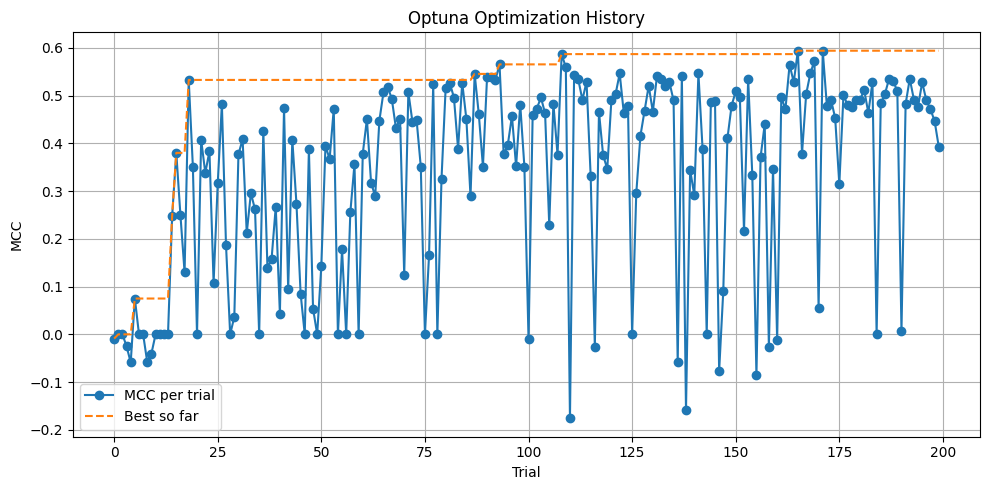

In [53]:
import matplotlib.pyplot as plt

values = [t.value for t in study.trials]

plt.figure(figsize=(10, 5))
plt.plot(values, marker="o", label="MCC per trial")
plt.plot(np.maximum.accumulate(values), label="Best so far", linestyle="--")
plt.title("Optuna Optimization History")
plt.xlabel("Trial")
plt.ylabel("MCC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()